# LAB: (quasi-) Newton methods

Author : Alexandre Gramfort

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
and compare your implementation with the BFGS and L-BFGS solvers in scipy

You will need to knowledge on **line search methods** and **conjugate gradient** in particular you should reuse the notebooks presented during the lectures.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 30th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 24 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "xiao"
ln1 = "pan"
fn2 = "yunzhi"
ln2 = "wu"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_pan_xiao_and_wu_yunzhi.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import timeit
from optim_utils import *
%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [25]:
from optim_utils import test_solver

You'll have work only with the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

Let us now make an example with a gradient descent.

In [33]:
def test_solver_plot(optimizer):
    x_min, x_max = -1, 2
    y_min, y_max = 2.25 / 3 * x_min - .2, 2.25 / 3 * x_max - .2
    x_min *= 1.2
    x_max *= 1.2
    y_min *= 1.2
    y_max *= 1.2

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
    
    for index, [ax, (f, f_prime, f_hessian)] in enumerate(zip(axes, (
            mk_quad(.7),
            mk_quad(.02),
            (rosenbrock, rosenbrock_prime, rosenbrock_hessian)))):

        print("\nRunning solver on case %d" % (index + 1))

        # Run optimization method logging all the function calls
        logging_f = LoggingFunction(f)
        x0 = np.array([1.6, 1.1])
        all_x_k, all_f_k = optimizer(x0, logging_f, f_prime, f_hessian)

        # Plot the convergence
        ax.semilogy(np.maximum(np.abs(all_f_k), 1e-30), linewidth=2,
                label='# iterations')
        #ax.ylabel('Error on f(x)')
        ax.semilogy(logging_f.counts,
                    np.maximum(np.abs(logging_f.all_f_x), 1e-30),
                    linewidth=2, color='g', label='# function calls')
        ax.legend(loc='upper right', frameon=True, prop=dict(size=11),
                  borderaxespad=0, handlelength=1.5, handletextpad=.5)
        plt.ylim((1e-18,1e3))
    plt.suptitle("the convergence of "+ optimizer.func_name)
    plt.show()

#### REMARK:
One function call corresponds to one attempt in line search.


In [26]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
    print("iter:%d" %k)
    return np.array(all_x_k), np.array(all_f_k)

Now I can call the `test_solver` function with this solver:


Running solver on case 1
iter:33

Running solver on case 2
iter:100

Running solver on case 3
iter:100


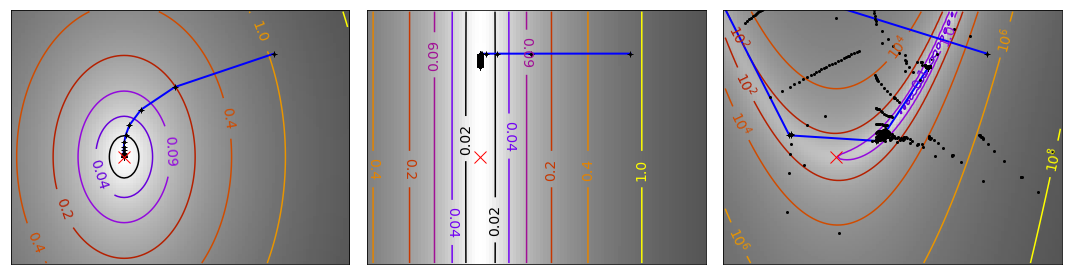

In [27]:
test_solver(gradient_descent)

# Part 2: Implement Newton method

You now need to implement Newton method using either `linalg.solve` or `sparse.linalg.cg` solve the linear system at each iteration. You need to implement both versions.

You're expected to comment in a few lines what you see.

In [6]:
import scipy.linalg as linalg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        ####################################
        # Compute here the search direction
        d = -np.linalg.solve(f_hessian(x),grad_x)
        ####################################
        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step
        
        ##################################
        # Compute here the new value of x
        x = x + d
        ##################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0, l_inf_norm(grad): 0

Running solver on case 2
iter: 1, f: 0, l_inf_norm(grad): 0

Running solver on case 3
iter: 1, f: 0.357547, l_inf_norm(grad): 1.19858
iter: 2, f: 0.253454, l_inf_norm(grad): 14.6168
iter: 3, f: 2.44184e-07, l_inf_norm(grad): 0.000988318
iter: 4, f: 5.96257e-12, l_inf_norm(grad): 9.76735e-05
iter: 5, f: 4.93038e-32, l_inf_norm(grad): 4.44089e-16


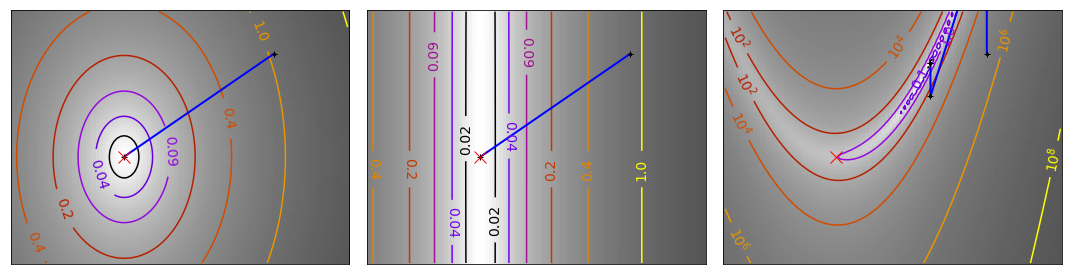

In [7]:
test_solver(newton)


Running solver on case 1
iter: 1, f: 0, l_inf_norm(grad): 0

Running solver on case 2
iter: 1, f: 0, l_inf_norm(grad): 0

Running solver on case 3
iter: 1, f: 0.357547, l_inf_norm(grad): 1.19858
iter: 2, f: 0.253454, l_inf_norm(grad): 14.6168
iter: 3, f: 2.44184e-07, l_inf_norm(grad): 0.000988318
iter: 4, f: 5.96257e-12, l_inf_norm(grad): 9.76735e-05
iter: 5, f: 4.93038e-32, l_inf_norm(grad): 4.44089e-16


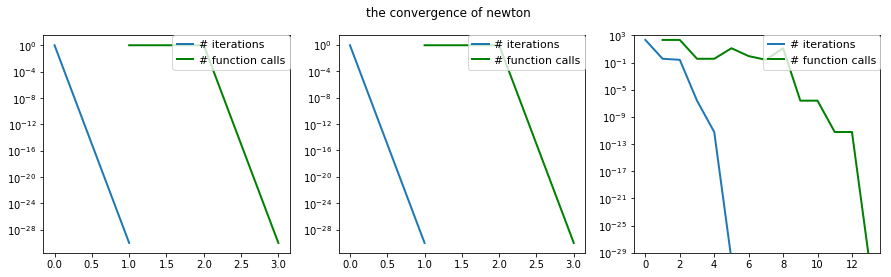

In [28]:
test_solver_plot(newton)

#### Comments:
- Newton descent method converges very fast:
    - Newton method has not only the first-order condition(the gradient) but also the second-order condition(the hessian), so Newton method is more wise in choosing the direction: it chooses the direction where the function should become steeper, while gradient descent only choose the direction where the function is steeper from a local view.
    - for quadratic problem (fig 1 and fig 2): it converges at the first descent regardless of the conditioning (i.e. the condition number) of the problem. But for non-quadratic problems it takes more steps such as Rosenbrock function.
- Line search is fast in Newton descent.

# Part 2: Implement DFP algorithm

You now need to implement the DFP algorithm.

In [8]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        ####################################
        # Compute here the search direction
        d = -B.dot(grad_x)
        ####################################

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        ##################################
        # Compute here the new value of x
        x = x + step*d
        ##################################
        
        #########################################################
        # Update the inverse Hessian approximation
        s = step*d
        y = new_grad - grad_x
#         tmp = B.dot(y)
#         part = np.outer(tmp,tmp)*1./y.dot(tmp)
#         B = B + np.outer(s,s)*1./s.dot(y) - part????????????????????????????????????????
        B = B + np.outer(s,s)*1./s.dot(y) - np.outer(B.dot(y),B.dot(y))*1./y.dot(B.dot(y))
        #########################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad
    print("iter:%d" %k)
    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter:8

Running solver on case 2
iter:6

Running solver on case 3
iter:92


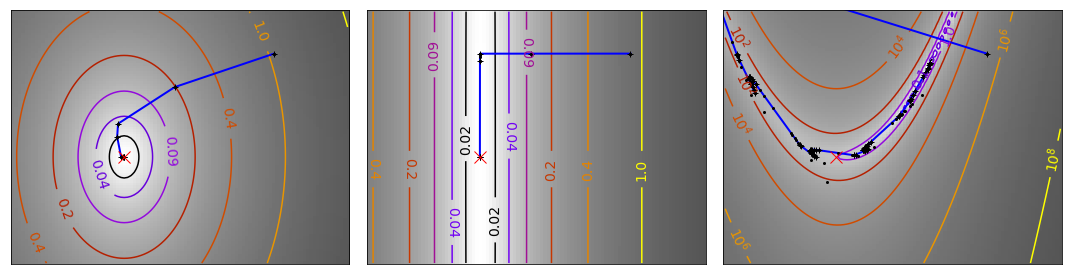

In [9]:
test_solver(dfp)


Running solver on case 1
iter:8

Running solver on case 2
iter:6

Running solver on case 3
iter:92


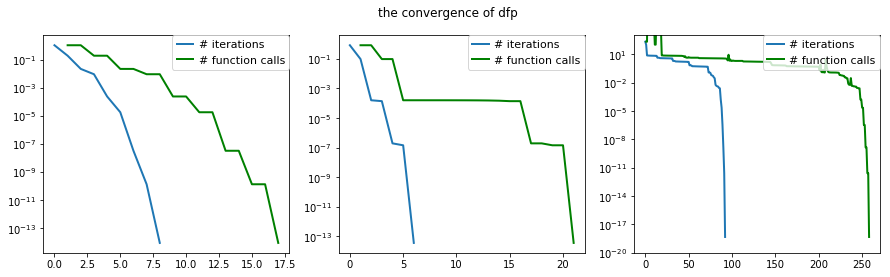

In [31]:
test_solver_plot(dfp)

#### Comments:
- The Quasi-Newton Descent Method still converges fast, but for quadratic problems, it does not converge as fast as the Newton descent method.
    - Because in Quasi-Newton Descent Method, we use an approximate of the Hessian matrix, not the 'true' Hessian. For example, in the first and second cases, they take more than one step to converge even though the objective function is quadratic. Also, in the third non-quadratic case, it takes more steps than Newton Descent does.
    - In the quadratic case, the algorithm behaves like a conjugate descent method, and should converge in at most n iterations. But in this case above we use approximate optimal step size in each iterration(Strong Wolfe Conditions), so it takes more steps to converge to the optimal. For instance, in the first case, if we use Quasi-Newton Descent with exact optimal step size it will take at most 2 steps to converge to optimum.

# Part 3: Implement BFGS algorithm

You now need to implement the BFGS algorithm.

In [10]:
def bfgs(x0, f, f_grad, f_hessian):
    start = timeit.default_timer()
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    H = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        ####################################
        # Compute here the search direction
        d = -np.linalg.solve(H,grad_x)
        ####################################

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        ##################################    
        # Compute here the new value of x
        x = x + step*d
        ##################################
        
        #####################################################
        # Update the Hessian approximation   
        s = step*d
        y = new_grad - grad_x
        H = H + np.outer(y,y)*1./s.dot(y) - np.outer(H.dot(s),H.dot(s))*1./s.dot(H.dot(s))
        #####################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad
    stop = timeit.default_timer()
    print("iter:%d" %k)
    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter:7

Running solver on case 2
iter:4

Running solver on case 3
iter:42


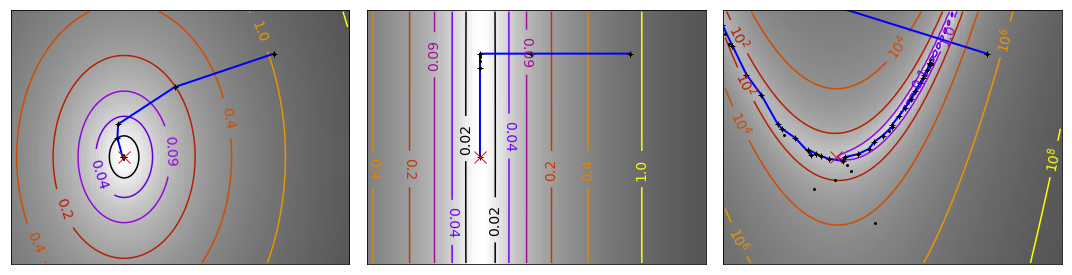

In [11]:
test_solver(bfgs)


Running solver on case 1
iter:7

Running solver on case 2
iter:4

Running solver on case 3
iter:42


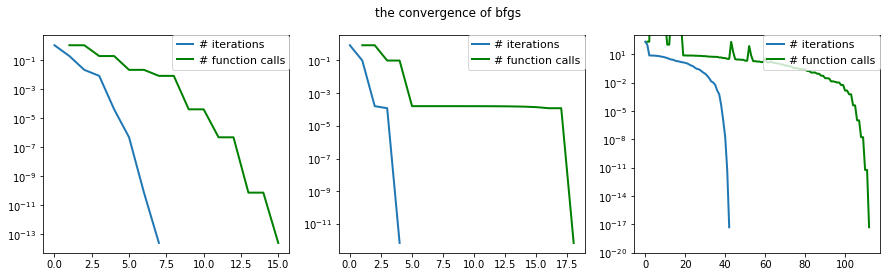

In [32]:
test_solver_plot(bfgs)

#### Comments:
- Using Strong Wolfe Rule for step size, BFGS converges to local optimum by less iterations, because BFGS is less sensitive to the use of approximate step size than DFP, which makes it more suitable to combine with Strong Wolfe Rule here. 

# Part 4: Do the same now with scipy implementation of BFGS and L-BFGS

In [12]:
from scipy.optimize import fmin_bfgs, fmin_l_bfgs_b
# TODO
def bfgs_scipy(x0, f, f_prime, hessian=None):
    all_x_k, all_f_k = list(), list()
    x = x0
    all_x_k.append(x.copy())
    all_f_k.append(f(x))
    
    def store(X):
        all_x_k.append(X.copy())
        all_f_k.append(f(X))
    start = timeit.default_timer()
    optimize.fmin_bfgs(f, x0, f_prime, callback=store, gtol=1e-12,disp = 1)
    stop = timeit.default_timer()
    print "Run time: %.3f ms" %(1000*(stop - start)) 
    return np.array(all_x_k), all_f_k

def l_bfgs_scipy(x0, f, f_prime, hessian=None):
    all_x_k, all_f_k = list(), list()
    x = x0
    all_x_k.append(x.copy())
    all_f_k.append(f(x))
    def store(X):
        all_x_k.append(X.copy())
        all_f_k.append(f(X))
    start = timeit.default_timer()
    _, _, d = optimize.fmin_l_bfgs_b(f, x0, f_prime, callback=store, pgtol=1e-12, disp=1, m=10)
    print d
    stop = timeit.default_timer()
    print "Run time: %.3f ms" %(1000*(stop - start))   
    return np.array(all_x_k), all_f_k


Running solver on case 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Run time: 3.323 ms

Running solver on case 2
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 12
         Gradient evaluations: 12
Run time: 2.819 ms

Running solver on case 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 28
         Function evaluations: 37
         Gradient evaluations: 37
Run time: 5.605 ms


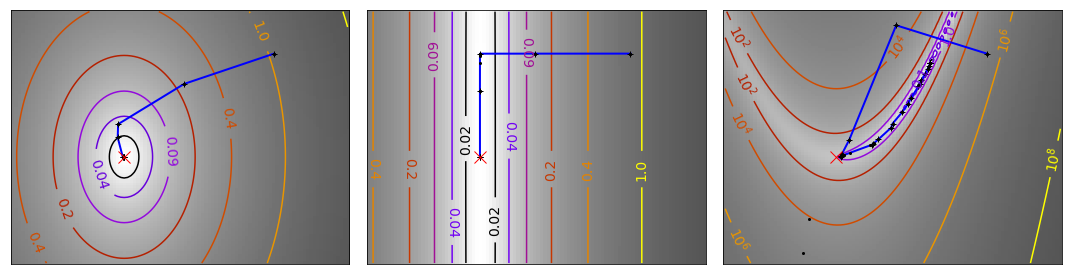

In [13]:
test_solver(bfgs_scipy)


Running solver on case 1
{'warnflag': 0, 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'grad': array([ -6.47665215e-10,   6.13751846e-09]), 'nit': 6, 'funcalls': 7}
Run time: 10.603 ms

Running solver on case 2
{'warnflag': 0, 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'grad': array([ -5.60020004e-11,  -6.43840445e-15]), 'nit': 5, 'funcalls': 10}
Run time: 1.387 ms

Running solver on case 3
{'warnflag': 0, 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'grad': array([  1.00038866e-10,  -5.23581178e-11]), 'nit': 20, 'funcalls': 23}
Run time: 4.060 ms


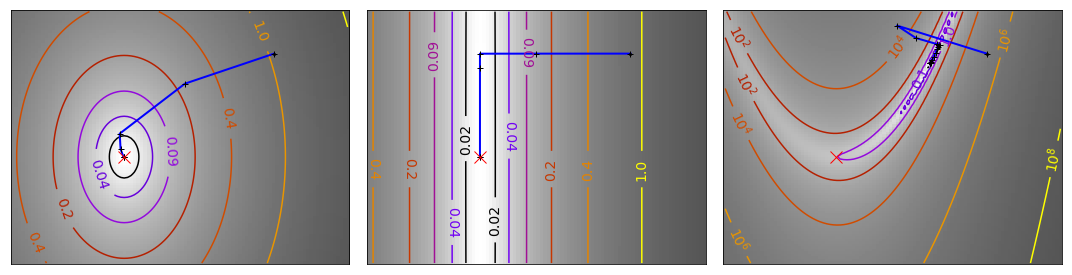

In [14]:
test_solver(l_bfgs_scipy)

#### Comments
- In the same conditions, the LBFGS takes less steps to converge in all the cases above. The convergence of LBFGS is especially better than BFGS in an ill-conditioned case(it goes a less tprtuous path). But it doesn't have necessary improvement in time.
- In quadratic cases both the algorithms converge to the optimum, while they converge to a local optimum in a non-quadratic case.
- The BFGS in scipy uses a bit more steps than that we wrote in the quadratic cases, but it performes much better in the ill-conditioned case.
- To look deeper into the performance of the BFGS and LBFGS, let's look into the linesearch. To get the information of linesearch process, we define the test_solver_plot function as following, which plots both the iteration of the algorithm and every step in linesearch.


Running solver on case 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Run time: 1.229 ms

Running solver on case 2
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 12
         Gradient evaluations: 12
Run time: 1.070 ms

Running solver on case 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 28
         Function evaluations: 37
         Gradient evaluations: 37
Run time: 4.006 ms


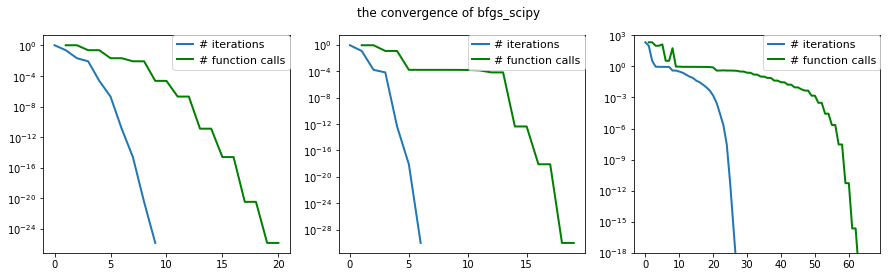


Running solver on case 1
{'warnflag': 0, 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'grad': array([ -6.47665215e-10,   6.13751846e-09]), 'nit': 6, 'funcalls': 7}
Run time: 1.926 ms

Running solver on case 2
{'warnflag': 0, 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'grad': array([ -5.60020004e-11,  -6.43840445e-15]), 'nit': 5, 'funcalls': 10}
Run time: 1.419 ms

Running solver on case 3
{'warnflag': 0, 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'grad': array([  1.00038866e-10,  -5.23581178e-11]), 'nit': 20, 'funcalls': 23}
Run time: 2.691 ms


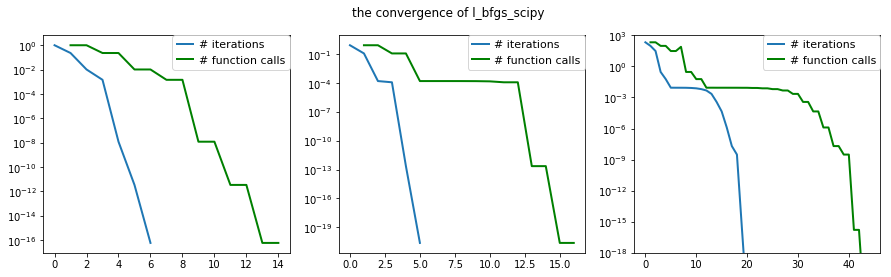

In [34]:
funcs = [bfgs_scipy, l_bfgs_scipy]
for i in funcs:
    test_solver_plot(i)

#### Comments
- At each iteration, the function value never increases, while at each function call, the function value might increse. 


- The BFGS algorithm using scipy converges faster than the previous 'bfgs'.Because in scipy, BFGS reinitialize its searching direction to $- \triangledown f$ periodically, but in our implementation, there is no reinitialization of direction.


- In L-BFGS, the value decreaes faster in each step of linesearch, which means the direction is better. Thus, L-BFGS converges in less steps than BFGS and consumes less time for complex problems.
     - Because in L-BFGS, the direction only backtrack to m steps before when necessary, not like in BFGS, where the direction should be reinitialized to $- \triangledown f$ periodically. So L-BFGS is faster.